# Introduction
For this exercise, I choose to use one of my own dataset. One of my friends asked me to try some work on their website, a french news site about computer games (https://nofrag.com/). They have news, a forum and so on. I decided to try RNN and LSTM networks on text data, as some of their news lost the author identification during server transfers. I hope to write a model learning the style of the different authors so I can correctly label the texts where the author is missing. 
I started by writing a web scraper with Selenium & BeautifulSoup to get all the news and different informations for other projects as well. I will not discuss this scraper as this is not the point of this exercise, but this is the origin of my dataset.
My project will be separated in different parts:

### 1. Presentation & EDA of the dataset.
### 2. SVM model for baseline comparison
### 3. RNN model and variations
### 4. LSTM model and varations


### 1. Presentation & EDA

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

Sub-function I use often for checking the presence of NaNs:

In [2]:
def check_for_nans(df):
    ''' This function will count the number of Nans in the dataframe and return a frame showing the percentage 
    per feature if there are any'''
    n_nan = (df.isna().sum())  # counting the number of Nan values
    n_nan = n_nan[n_nan > 0] # Keep only the features if there are Nan inside
    
    
    if n_nan.shape[0] > 0: # If there are Nan values, show the percentage per feature
        print('\033[1m' + 'There are NaN Values in the dataset.' + '\033[0m')
        percent_nan = n_nan / df.shape[0] * 100
        df_nan = pd.DataFrame({'feature': n_nan.index, 
                               'number_nan': n_nan.values, 
                               'percent_nan':percent_nan.values})
        
        return df_nan.sort_values(by='percent_nan', ascending = False)
        
    else: # If there are no Nan values, simply say it.
        print('\033[1m' + 'There are no NaN values in the dataset.' + '\033[0m')
    
        return

The file was originally saved as xlsx format.

In [3]:
raw = pd.read_excel('NF_News_Clean.xlsx')

raw.head(5)

,Unnamed: 0,url,author,date,title,tags,n_comments,text
0,0,https://nofrag.com/putain-20-ans-les-fps-de-20...,nounoursss,2021-03-08 04:06:00,"Putain, 20 ans ! Les FPS de 2017 à 2020 : la m...",NaN,1,"L’année 2017 En 2017, pendant que les français..."
1,1,https://nofrag.com/retrouvez-noscope-9-fevrier...,Rutabaga,2021-02-28 09:16:00,Retrouvez NoScope #9 – février 2021,NoScope,4,Nous avons enregistré hier soir le neuvième ép...
2,2,https://nofrag.com/putain-20-ans-les-fps-de-20...,nounoursss,2021-03-07 03:50:00,"Putain, 20 ans ! Les FPS de 2013 à 2016 : la n...",NaN,6,"L’année 2013 En 2013, pendant que l’on découvr..."
3,3,https://nofrag.com/doom-eternal-the-ancient-go...,Xan K,2021-03-07 20:48:00,DOOM Eternal: The Ancient Gods – Part Two se m...,DOOM Eternal,2,C’est par le biais du compte Twitter officiel ...
4,4,https://nofrag.com/putain-20-ans-les-fps-de-20...,nounoursss,2021-03-06 05:08:00,"Putain, 20 ans ! Les FPS de 2009 à 2012 : nais...",NaN,10,"L’année 2009 En 2009, alors que la France conn..."


Columns names are quite informative as-is: index, url of the news, author, date the news was written, title, tags, number of comments and the text itself. In this exercise we will use onlyt the "author" and "text" features, so removing all the rest.

In [4]:
df = raw.drop(['url', 'Unnamed: 0', 'tags', 'title', 'n_comments', 'date'], axis = 1)

Some texts are missing, because they were not present on the website. I remove them here.

In [5]:
df = df[df['text'] != 'None']


And here is the final data I will be using. The author and the text, that's all.

In [6]:
df.head(5)

,author,text
0,nounoursss,"L’année 2017 En 2017, pendant que les français..."
1,Rutabaga,Nous avons enregistré hier soir le neuvième ép...
2,nounoursss,"L’année 2013 En 2013, pendant que l’on découvr..."
3,Xan K,C’est par le biais du compte Twitter officiel ...
4,nounoursss,"L’année 2009 En 2009, alors que la France conn..."


Let's check how many different authors there were and the number of news they wrote:

In [7]:
author_list = df['author'].value_counts().sort_values(ascending = False)

author_list[:10]

Netsabes          8128
drloser           5484
nounoursss        2562
Arthur Jeannin    1729
Noddus            1128
Fcp               1050
Rutabaga           874
Kemelvor           671
Shua               569
Masiko             446
Name: author, dtype: int64

The authors are quite unbalanced, I will use only the 3 first ones for this exercise. It will make things simpler and more reliable.

In [8]:
to_keep = ['Netsabes', 'drloser', 'nounoursss']
df2 = df[df['author'].isin(to_keep) ]

And let's check if we have any NaNs in the dataset:

In [9]:
check_for_nans(df2)

There are NaN Values in the dataset.


,feature,number_nan,percent_nan
0,text,16,0.098924


I wrote the scraper and it was a pain to fine tune but at least I have really few NaNs. We can remove them.

In [10]:
df2 = df2.dropna(axis=0,how="any")

df2.shape

(16158, 2)

And this is our dataset prepared for learning text: 16158 observations, 3 labels, no missing values. The labels are unbalanced (3 to 1 in the worst situation). In the different examples I found, it is recommanded to balance the set for text classification but they concerned heavily unbalanced sets (100 to 1 or even 1000 to 1, for example). So, to keep things simple I decided to not correct for unbalanced labels. However, I will always use the ROC-AUC as validation settings to take this into account.

In [11]:
df2.sample(10)

,author,text
10801,drloser,"Aussi inattendu que surprenant, Eidos vous off..."
23293,Netsabes,Le troisième DLC (General Knoxx) de Borderland...
15635,drloser,L’édition Premium de Bioshock Infinite (80$) c...
12624,Netsabes,"L’alpha 6.3 de 7 Days to die est sortie, avec ..."
17961,drloser,"Tiré du .plan, euh du compte Twitter de John C..."
18304,drloser,En fouillant dans le flux RSS du site officiel...
20756,Netsabes,Un petit groupe de Russes fous bosse depuis qu...
2325,nounoursss,"Chaque semaine ou presque, je vous propose de ..."
3649,nounoursss,"Pour les fermiers, Slime Rancher est offert su..."
14978,Netsabes,Lors de la présentation de ses résultats finan...


### 2. SVM model as baseline comparison
From a quick research, I could see that SVM models are considered quite good for text classification. I decided to use one for a "baseline" categorization of my texts, with a "Bag of Words" method. For this, I will use the SGDCLassifier from SKLearn, it is a SVM with gradient descent when using the default settings.
But first, of course I have to encode my labels:

In [12]:
from sklearn.preprocessing import LabelEncoder, label_binarize
le = LabelEncoder()

df2['author'] = le.fit_transform(df2['author'])

Define my features and labels:

In [13]:
X = df2['text']
y = df2['author']

And separate into train and test sets:

In [14]:
from sklearn.model_selection import train_test_split
X_train_svm, X_test_svm, y_train_svm, y_test_svm = train_test_split(X, y, test_size=0.3, random_state=42)

Moreover, I will use a gridsearch to find the best parameters among a small set of them.
CountVectorizer transforms our text into vectors (text to numbers), TfidfTransformer will set it (or not) as frequency of words.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn import svm


# Pipeline here. I use a log loss to get a multi-classifier.
auth_clf = Pipeline([('vect', CountVectorizer()),
                     ('tfidf', TfidfTransformer()),
                     ('clf', SGDClassifier(loss='log', 
                                           penalty='l2',
                                           alpha=1e-3, 
                                           random_state=42
                                           ))
                    ])

# Grid parameters with "__" to access the different steps
grid_params = {'vect__ngram_range': [(1, 1), (1, 2)],
               'tfidf__use_idf': (True, False), # Use idf or not
               'clf__alpha': (1e-2, 1e-3, 1e-4),
               'clf__penalty': ['l2'] # l2 regularization for SVM
              }
# GridSearchCV with auc scoring as our classes are unbalanced
auth_pipe = GridSearchCV(auth_clf, grid_params, cv=5, scoring='roc_auc_ovo')


In [16]:
auth_pipe.fit(X_train_svm, y_train_svm)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(alpha=0.001, loss='log',
                                                      random_state=42))]),
             param_grid={'clf__alpha': (0.01, 0.001, 0.0001),
                         'clf__penalty': ['l2'],
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2)]},
             scoring='roc_auc_ovo')

In [17]:
y_pred_svm = auth_pipe.predict(X_test_svm)
y_pred_proba_svm = auth_pipe.predict_proba(X_test_svm)

Here are the best parameters found by the GridSearch:

In [18]:
auth_pipe.best_params_

{'clf__alpha': 0.0001,
 'clf__penalty': 'l2',
 'tfidf__use_idf': True,
 'vect__ngram_range': (1, 2)}

We can see the result is better when using tfidf (which was expected) and when we group the words per two.
What are the metrics on our fit?

In [19]:
from sklearn.metrics import classification_report as clf_report
print(clf_report(y_test_svm, y_pred_svm, target_names = to_keep))

              precision    recall  f1-score   support

    Netsabes       0.83      0.94      0.88      2449
     drloser       0.88      0.72      0.79      1639
  nounoursss       0.99      0.93      0.96       760

    accuracy                           0.87      4848
   macro avg       0.90      0.86      0.88      4848
weighted avg       0.87      0.87      0.86      4848



We can see that even if the authors are unbalanced, the one with the smallest amount of news has the best precision. It seems he writes really differenty from the other two. The other two have similar scores, around 0.85 precision. Let's plot ROC and confusion matrixes:

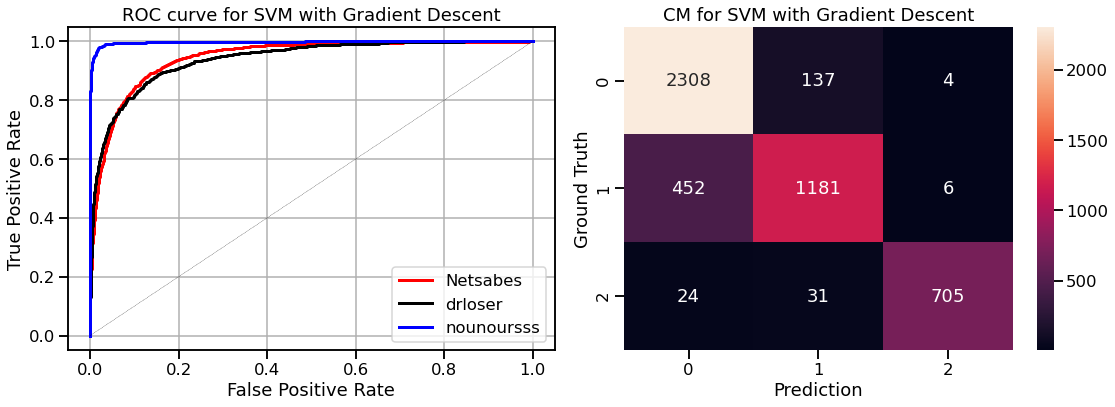

In [20]:
from sklearn.metrics import confusion_matrix, roc_curve, auc

def plot_metrics(test, pred, pred_proba, name):
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    test_lb = label_binarize(test, classes = np.arange(len(to_keep)))

    for i in range(len(to_keep)):
        fpr[i], tpr[i], _ = roc_curve(test_lb[:, i], pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])


    sns.set_context('talk')

    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(16, 6)

    # ROC Curves to the left
    ax = axList[0]
    colors = ['red', 'black', 'blue', 'green', 'purple']
    for i, color in zip(range(len(to_keep)), colors):
        ax.plot(fpr[i], tpr[i], color=color, lw=3, label=to_keep[i])

    ax.plot([0, 1], [0, 1], ls='--', color='black', lw=.3)
    ax.set(xlabel='False Positive Rate',
           ylabel='True Positive Rate',
           title='ROC curve for ' + name )
    ax.legend(loc="lower right")
    ax.grid(True)   


    # Confusion Matrix to the right
    ax = axList[1]

    ax = sns.heatmap(confusion_matrix(test, pred), annot=True, fmt='d');
    ax.set(title='CM for ' + name,
           xlabel = 'Prediction',
           ylabel = 'Ground Truth');

    plt.tight_layout()
    
plot_metrics(y_test_svm.values, y_pred_svm, y_pred_proba_svm, 'SVM with Gradient Descent')

And this is our baseline classification method for our news. Not bad in itself: one of the 3 authors is easily classified. The other 2 have quite the same score.
Now, we can try to improve this result by using recurrent neural networks.


### 3. Simple RNN and variations

As a reminder, here is our dataset: authors are label-encoded and the text is not modified.

In [21]:
df2.sample(10)

,author,text
17435,1,Fishbed rédige un compte rendu complet sur l’é...
16822,0,CCP a ouvert les inscriptions pour la bêta de ...
26694,0,"«Quake fans, this one’s for you. Enjoy.» –JCal..."
19315,1,"Je n’aime pas les puzzles, donc je n’aime pas ..."
23172,0,Les premiers détails sur Ghost Recon: Future S...
21527,0,Valve parle (rapidos) de ce qui a changé pour ...
23671,0,Le rachat par ZeniMax a peut-être du bon : id ...
15852,0,"Cryostasis, le dernier jeu des Ukrainiens d’Ac..."
26893,1,Ah! les hommes politiques… Ce sont des gens co...
3099,2,World War 3 organise un week-end gratuit du 20...


First, a sub-function to prepare the text. When using the SVM pipeline, the CountVectorizer step was doing this but now we will do it manually with Tokenizer to transform text into integers and pad_sequences to obtain regular-sized matrixes.

In [22]:
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def prepare_text(text_array, max_words = 50000, max_length=250):
    '''This function will return mx_length matrixes with max_words numbers'''
    
    # Default Tokenizer. 
    # Not really proper as I do not use english. See the end of this exercise.
    tokenizer = Tokenizer(num_words=max_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=False)
    tokenizer.fit_on_texts(text_array)
    
    word_index = tokenizer.word_index
    print('Number of unique words: ', len(word_index))
    
    X = tokenizer.texts_to_sequences(text_array)
    X = pad_sequences(X, maxlen=max_length)
    print('Shape of train data:', X.shape)
    
    return X
    

Transformation of my text in matrixes of int and one-hot-encoding of the labels.
I check the sizes to be certain it fits.
I use a max_words of 1000, which is quite low. But we are talking about news about computer games, the vocabulary should not be really complicated and this will speed things up.

In [23]:
max_words = 1000
max_length = 50
word_embedding_dim = 10

X_rnn = prepare_text(df2['text'].values, max_words = max_words, max_length = max_length )

y_rnn = pd.get_dummies(df2['author']).values
print('Shape of label data:', y_rnn.shape)

Number of unique words:  70496
Shape of train data: (16158, 50)
Shape of label data: (16158, 3)


Separation in train and test sets, still checking the dimensions (I got some trouble with those).

In [24]:
X_train_rnn, X_test_rnn, y_train_rnn, y_test_rnn = train_test_split(X_rnn,y_rnn, 
                                                                    test_size = 0.3, random_state = 42)
print(X_train_rnn.shape,y_train_rnn.shape)
print(X_test_rnn.shape,y_test_rnn.shape)

(11310, 50) (11310, 3)
(4848, 50) (4848, 3)


And here is the RNN, same one than in the lesson. However, I shifted to softmax activation for multi-classification.

In [25]:
from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import SimpleRNN

from tensorflow.keras import initializers

rnn_hidden_dim = 5
batch_size = 32

model_rnn = Sequential()
model_rnn.add(Embedding(max_words, word_embedding_dim))  
model_rnn.add(SimpleRNN(rnn_hidden_dim,
                    kernel_initializer=initializers.RandomNormal(stddev=0.001),
                    recurrent_initializer=initializers.Identity(gain=1.0),
                    activation='relu',
                    input_shape=X_train_rnn.shape[1:]))

model_rnn.add(Dense(len(to_keep), activation='softmax'))

In [26]:
model_rnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 10)          10000     
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 5)                 80        
_________________________________________________________________
dense (Dense)                (None, 3)                 18        
Total params: 10,098
Trainable params: 10,098
Non-trainable params: 0
_________________________________________________________________


Categorical crossentropy for multiple classifications and AUC scoring as our classes are slightly unbalanced.

In [27]:
from tensorflow.keras.metrics import AUC

model_rnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['AUC'])


In [28]:
model_rnn.fit(X_train_rnn, y_train_rnn,
              batch_size=batch_size,
              epochs=5,
              validation_data=(X_test_rnn, y_test_rnn))

Epoch 1/5
354/354 [==============================] - 6s 12ms/step - loss: 0.7914 - auc: 0.8046 - val_loss: 0.6526 - val_auc: 0.8765
Epoch 2/5
354/354 [==============================] - 4s 11ms/step - loss: 0.5814 - auc: 0.9006 - val_loss: 0.5466 - val_auc: 0.9121
Epoch 3/5
354/354 [==============================] - 4s 13ms/step - loss: 0.4767 - auc: 0.9351 - val_loss: 0.4768 - val_auc: 0.9360
Epoch 4/5
354/354 [==============================] - 4s 10ms/step - loss: 0.4125 - auc: 0.9519 - val_loss: 0.4450 - val_auc: 0.9434
Epoch 5/5
354/354 [==============================] - 4s 11ms/step - loss: 0.3804 - auc: 0.9587 - val_loss: 0.4549 - val_auc: 0.9427


After 5 epochs, let's check the loss and AUC evolution:

In [29]:
def plot_history(model, name):
    
    sns.set_context('talk')

    fig, axList = plt.subplots(ncols=2)
    fig.set_size_inches(16, 6)

    # Loss Curves to the left
    ax = axList[0]

    ax.plot(model.history.history['loss'], label='train set')
    ax.plot(model.history.history['val_loss'], label='test set')

    ax.set(xlabel='Epochs',
           ylabel='Loss Value',
           title='Loss Evolution for ' + name)

    ax.legend()

    # AUC to the right
    ax = axList[1]

    ax.plot(model.history.history['auc'], label='train set')
    ax.plot(model.history.history['val_auc'], label='test set')
    ax.legend()
    ax.set(xlabel='Epochs',
           ylabel='AUC Value',
           title='AUC Evolution for ' + name)

    plt.tight_layout()


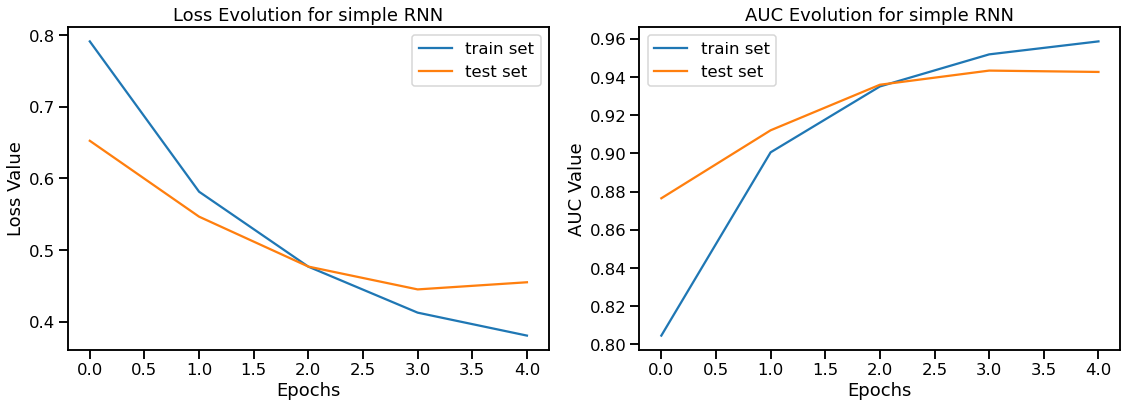

In [30]:
plot_history(model_rnn, 'simple RNN')

From this quict test, we can see that 3 epochs are enough to reach a plateau in AUC scoring.
We can plot the ROC and confusion matrix as well, after some transformation of the results (the model yields one-hot-encoded predictions, but we need them label-encoded:

In [31]:
def calculate_and_plot_metrics(model, X_test, y_test, name):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)

    y_test_plots = np.argmax(y_test, axis = 1)
    
    plot_metrics(y_test_plots, y_pred, y_pred_proba, name)

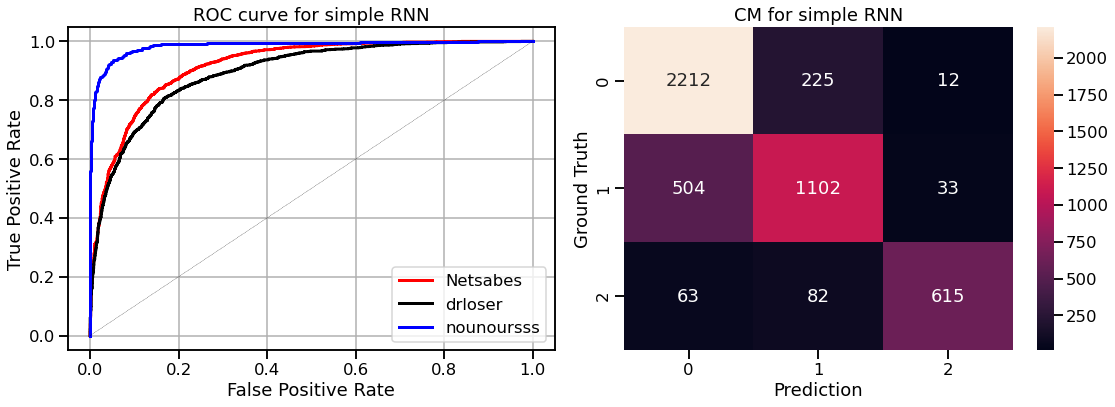

In [32]:
calculate_and_plot_metrics(model_rnn, X_test_rnn, y_test_rnn, 'simple RNN')

We can see that this simple RNN model is worse than the SVM model. What if we train this model for 10 more epochs?

In [33]:
model_rnn.fit(X_train_rnn, y_train_rnn,
          batch_size=batch_size,
          epochs=10,
          validation_data=(X_test_rnn, y_test_rnn))

Epoch 1/10
354/354 [==============================] - 4s 13ms/step - loss: 0.3513 - auc: 0.9646 - val_loss: 0.4574 - val_auc: 0.9407
Epoch 2/10
354/354 [==============================] - 4s 11ms/step - loss: 0.3348 - auc: 0.9677 - val_loss: 0.4633 - val_auc: 0.9414
Epoch 3/10
354/354 [==============================] - 4s 11ms/step - loss: 0.3214 - auc: 0.9703 - val_loss: 0.4514 - val_auc: 0.9438
Epoch 4/10
354/354 [==============================] - 4s 11ms/step - loss: 0.3164 - auc: 0.9712 - val_loss: 0.4705 - val_auc: 0.9391
Epoch 5/10
354/354 [==============================] - 4s 10ms/step - loss: 0.3053 - auc: 0.9730 - val_loss: 0.4629 - val_auc: 0.9442
Epoch 6/10
354/354 [==============================] - 4s 10ms/step - loss: 0.2966 - auc: 0.9744 - val_loss: 0.4681 - val_auc: 0.9426
Epoch 7/10
354/354 [==============================] - 4s 11ms/step - loss: 0.2911 - auc: 0.9754 - val_loss: 0.4937 - val_auc: 0.9411
Epoch 8/10
354/354 [==============================] - 4s 11ms/step - 

We can directly plot the history and the metrics after that:

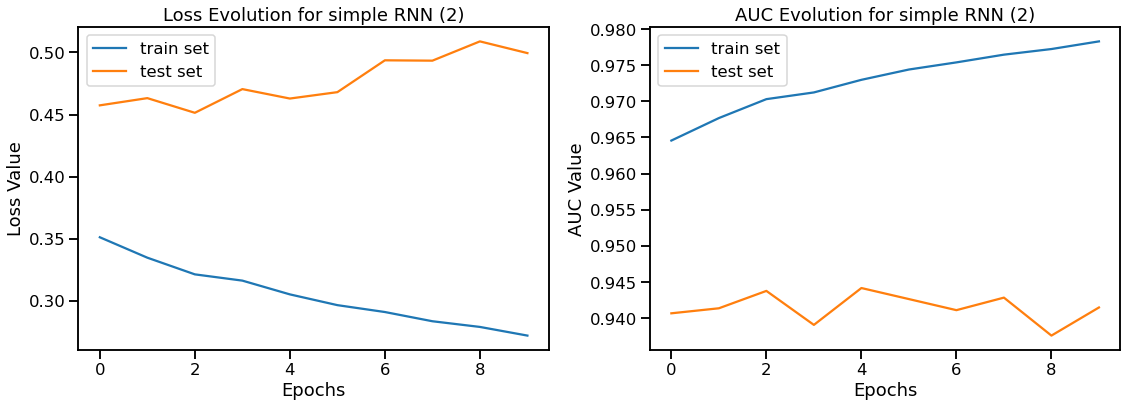

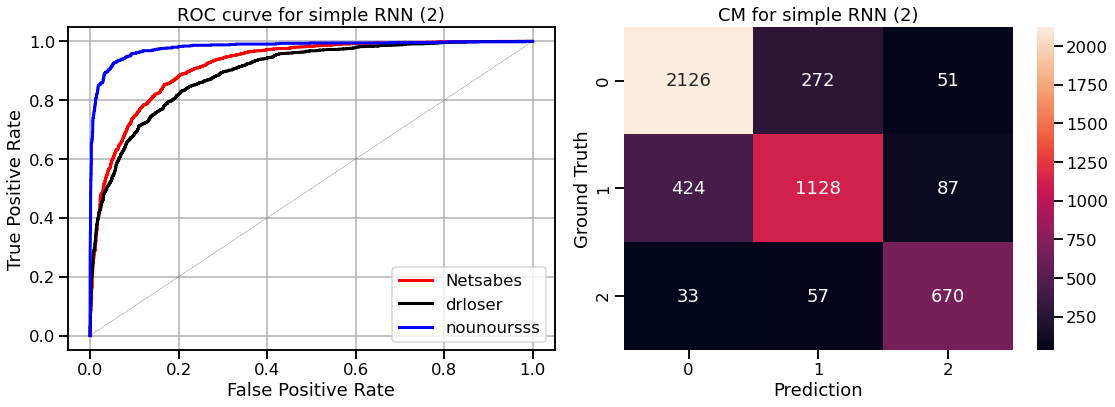

In [34]:
plot_history(model_rnn, 'simple RNN (2)')

calculate_and_plot_metrics(model_rnn, X_test_rnn, y_test_rnn, 'simple RNN (2)')

Metrics are not really improving and we start to see some clear overfitting. 3 - 5 epochs were enough with these settings.

We can try with another model, LSTM.

### 4. LSTM model and variations

In [35]:
from tensorflow.keras.layers import SpatialDropout1D, LSTM

We will create a really simple LSTM model with 100 neurons and similar parameters than the previous RNN model. We will use the same train and test sets than for the RNN model.

In [36]:
model_lstm = Sequential()
model_lstm.add(Embedding(max_words, word_embedding_dim, input_length=X_train_rnn.shape[1]))
model_lstm.add(SpatialDropout1D(0.2))
model_lstm.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model_lstm.add(Dense(len(to_keep), activation='softmax'))
model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['AUC'])

epochs = 10
batch_size = 64

model_lstm.fit(X_train_rnn, y_train_rnn,
               epochs=epochs, batch_size=batch_size,
               validation_data=(X_test_rnn, y_test_rnn))

Epoch 1/10
177/177 [==============================] - 23s 104ms/step - loss: 0.8135 - auc: 0.7950 - val_loss: 0.6948 - val_auc: 0.8505
Epoch 2/10
177/177 [==============================] - 15s 85ms/step - loss: 0.6683 - auc: 0.8589 - val_loss: 0.6286 - val_auc: 0.8778
Epoch 3/10
177/177 [==============================] - 15s 85ms/step - loss: 0.6135 - auc: 0.8830 - val_loss: 0.5997 - val_auc: 0.8915
Epoch 4/10
177/177 [==============================] - 15s 86ms/step - loss: 0.5795 - auc: 0.8993 - val_loss: 0.5599 - val_auc: 0.9068
Epoch 5/10
177/177 [==============================] - 15s 85ms/step - loss: 0.5097 - auc: 0.9247 - val_loss: 0.4839 - val_auc: 0.9324
Epoch 6/10
177/177 [==============================] - 15s 87ms/step - loss: 0.4525 - auc: 0.9414 - val_loss: 0.4945 - val_auc: 0.9321
Epoch 7/10
177/177 [==============================] - 19s 107ms/step - loss: 0.4166 - auc: 0.9507 - val_loss: 0.4508 - val_auc: 0.9451
Epoch 8/10
177/177 [==============================] - 14s 82

And here are the history and metrics:

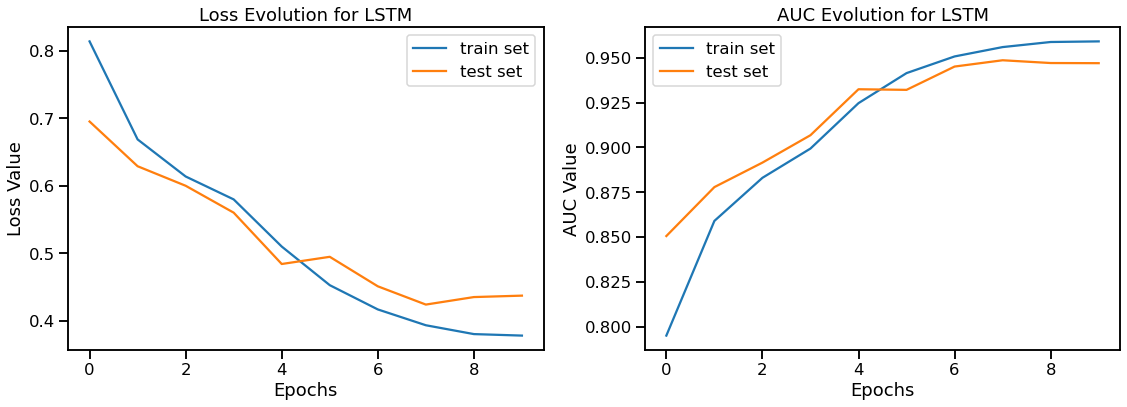

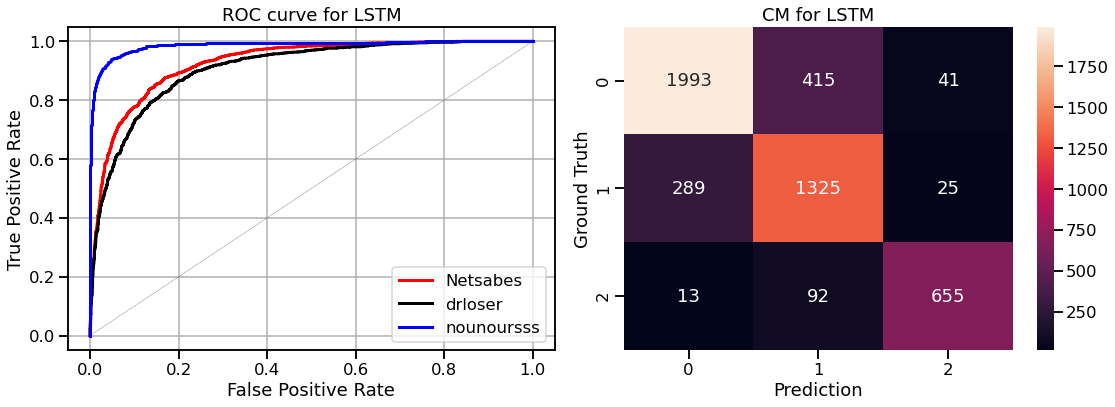

In [37]:
plot_history(model_lstm, 'LSTM')

calculate_and_plot_metrics(model_lstm, X_test_rnn, y_test_rnn, 'LSTM')


This LSTM model is better than the RNN model. 5 - 6 epochs are enough to reach a prediction plateau.
I wanted to improve this result further, and then decided to restart from the beginning.

First, as I said before, the default Tokenizer is not really appropriate for french text. Stopwords are defined for english, thus keeping every words of the french text and not removing the common "the", "and", etc...
It is possible to do it manually with nltk. Moreover, I will remove every upper case letters, symbols, punctuation and event accents. This will give an ugly result (us french love our accented letters) but this should simplify the text at maximum.

In [38]:
import nltk
import re
nltk.download('stopwords')

def clean_text(text):
    from nltk.corpus import stopwords
    
    # this will remove all but letters
    replace_by_space = re.compile('[/(){}\[\]\|@,;]')
    remove_symbols = re.compile('[^0-9a-z #+_]')
    
    # And now using french stopwords
    stopwords = set(stopwords.words('french')) 
    
    text = text.lower() # Everything in lower case first
    text = replace_by_space.sub(' ', text) 
    text = remove_symbols.sub('', text)
    
    text = ' '.join(word for word in text.split() if word not in stopwords)
    return text

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Syla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [39]:
df2['text'] = df2['text'].apply(clean_text)

And here is the result on the text:

In [40]:
df2.sample(10)

,author,text
17933,0,employ goldtooth interactive studio responsabl...
948,2,hot dogs horseshoes hand grenades h3vr vient p...
4772,2,nouvelle note blog lquipe derrire rainbow six ...
13649,1,vendredi huit dveloppeurs dinterstellar marine...
16733,0,rikochet tait fps ind multijoueur dvelopp plas...
14221,1,pouvez couter gratuitement 24 musiques bande r...
20603,0,petit patch garrys mod
13395,0,eldritch fpsroguelike base gros cthulhu sortir...
15272,1,nombreux regretter manque difficult dishonored...
23719,0,valve a mis jour rsultats sondage matriel 45 p...


Second, I will use higher parameters for the text tokenization, to take more words into account and more combinations of words as well:

In [41]:
max_words = 2000
max_length = 50
word_embedding_dim = 20

X = prepare_text(df2['text'].values, max_words = max_words, max_length = max_length )

y = pd.get_dummies(df2['author']).values
print('Shape of label data:', y.shape)

Number of unique words:  55924
Shape of train data: (16158, 50)
Shape of label data: (16158, 3)


In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(11310, 50) (11310, 3)
(4848, 50) (4848, 3)


And third, to find the optimal parameters, I realised I can use a GridSearchCV with Keras models.
KerasClassifier is a wrapper that can be used in a pipeline and a gridsearch from SKLearn. This is extremely handy to search through a parameter grid, but of course computation time explodes. I had to limit the grid to keep things manageable. Moreover, the clear_session method is absolutely necessary to remove old models from the GridSearch. Without it, it takes too much memory. I tried to run the Notebook on Watson as well, but it did not improve things significantly. The single parameters I present are the result of multiple trials, changing few things each time so my computer does not melt.

In [43]:
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import backend

In [44]:
# First, create the neuronal model with default settings
def create_lstm(neurons = 100, 
                spatial_dropout = 0.2,
                drop_out = 0.2,
                optimizer = 'adam'):
    # Clearing session before creating new model. MANDATORY.
    backend.clear_session()
    
    model_lstm = Sequential()
    model_lstm.add(Embedding(max_words, word_embedding_dim, input_length=X_train.shape[1]))
    model_lstm.add(SpatialDropout1D(0.2))
    model_lstm.add(LSTM(neurons, dropout=drop_out, recurrent_dropout=0.2))
    model_lstm.add(Dense(len(to_keep), activation='softmax'))
    model_lstm.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['AUC'])
    
    return model_lstm


'''
Different parameters I tried.
neurons = [20, 50, 100, 200]
spatial_dropout = [0.0, 0.2, 0.4]
drop_out = [0.0, 0.2, 0.4]
batch_size = [16, 24, 32, 64]
optimizer = ['Adagrad', 'Adadelta', 'Adam']
epochs = [5, 10, 20]
'''

# Grid Parameters. 
# Kinf of the best I could find after many trials.
neurons = [20]
spatial_dropout = [0.2]
drop_out = [0.2]
batch_size = [24]
optimizer = ['Adam']
epochs = [10] # In the previous test, 5 was enough.

param_grid = dict(neurons = neurons,
                  spatial_dropout = spatial_dropout,
                  drop_out = drop_out,
                  batch_size = batch_size,
                  epochs = epochs,
                  optimizer = optimizer
                 )

# Model is declared here for GridSearch.
model = KerasClassifier(build_fn=create_lstm, verbose=0)

# Grid object here. Scoring has to be the same than the model object.
grid = GridSearchCV(estimator=model, 
                    param_grid=param_grid, 
                    cv=3, scoring ='roc_auc_ovo',
                    n_jobs=-1)



In [45]:
# This will take forever.
grid_result = grid.fit(X_train, y_train)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: 0.933301 using {'batch_size': 24, 'drop_out': 0.2, 'epochs': 10, 'neurons': 20, 'optimizer': 'Adam', 'spatial_dropout': 0.2}


In [46]:
y_pred_proba = grid_result.predict_proba(X_test)
y_pred = np.argmax(y_pred_proba, axis = 1)
y_test_plot = np.argmax(y_test, axis = 1)

And the metrics:

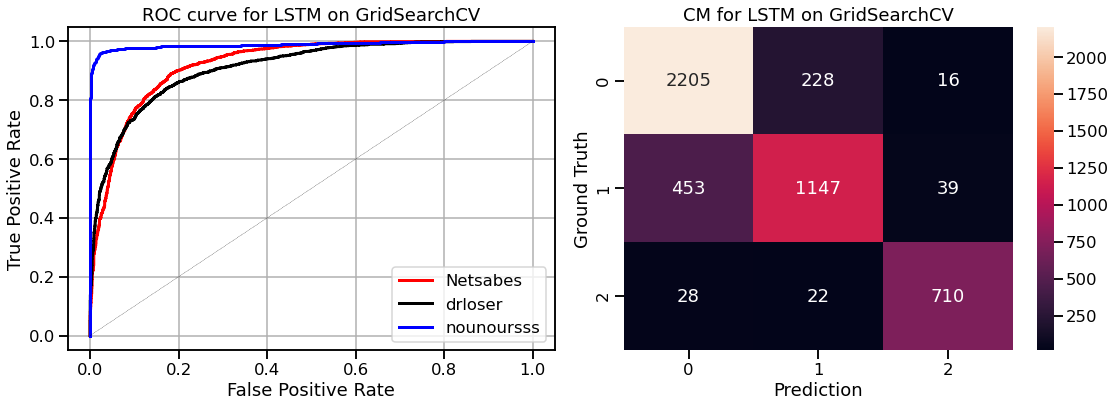

In [47]:
plot_metrics(y_test_plot, y_pred, y_pred_proba, 'LSTM on GridSearchCV')

We can see it is working fine, with one label clearly better identified, but it is slightly worse than the first "Bag of Words" approach.

## Conclusion
I used my own dataset made of text news and tried to set different algorithms in order to classify them by authors. I used a regular machine-learning SVM as a baseline as a baseline classification and tried to improve the score by using RNN and LSTM models. I used an RNN with 2 different numbers of Epochs, a LSTM in standard conditions and with a gridsearch approach, which makes 4 variatons of neural models.

### Model choice.
The best models reached more than 90% AUC. One label is clearly better identified than the others, which is a hint the style is different. 
The original SVM model, using a "Bag of Words" approach works quite well and is inexpensive compared to other deep neuronal networks. Depending on the needs and available resources, this might be the best choice. The RNN performed  worse with default settings, LSTM seemed to be better in this regard.
I could se that some tries improved one label or the others compared to the SVM model, which indicates that fine-tuning hyper parameters would probably improve these models. However, this takes a lot of computational resources and I could not do it thoroughly. Interestingly, the GridSearch I did on the LSTM model made me decrease many of the original settings I used: from 100 to 20 neurons, for example. I was overfitting at the beginning.

### Things to improve.
Beside having more work power, many things can be improved. First, as explained, default settings of tokenization process are made for english language. I tried to simplify my text but take more words into account, maybe this was a bad idea. Second, I wanted to work on text only but I should probably use other features available in the dataset such as the date, tags, etc... Third, I have to try these models for more than 3 authors. Ideally I would like to identify around 10 authors (the most common ones) however this will increase computing time dramatically and I will  need to balance my dataset.